In [1]:
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('infile', type=str)

_StoreAction(option_strings=[], dest='infile', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help=None, metavar=None)

## Import data
The test data was exported from FlowJo v9 table editor using the "Save" button to save as a tab-delimited text file. TSV is necessary in this case, because FlowJo uses commas in the gate descriptions.

In [3]:
df = pd.read_table(filepath_or_buffer="jw112_cytokine_test.tsv", encoding="mac_roman")

**Note:** There is an import error when encoding is not specified - changing the encoding to `"mac_roman"` within the `pd.read_table()` call allowed import, but might not be applicable to all platforms. It might be useful to include an encoding conversion step using something like `chardet`.

In [4]:
# Drop mean and standard deviation rows
df = df.drop(df.tail(2).index)

## Add grouping variables as new column(s)
I will try to add grouping variables using a function to repeat a sequence of strings and add as a new column.

In [5]:
genotypes = ['KO', 'WT', 'KO', 'WT', 'KO']
organs = ["Spleen", "PP", "coLP"]

In [6]:
df.insert(1, "genotype", np.tile(genotypes, 3))
df.insert(2, "organ", np.repeat(organs, 5))

In [7]:
df.tail()

,Sample,genotype,organ,"Cells/Singlets/Live/TCRb+CD4+/GM-CSF+,Freq. of Parent","Cells/Singlets/Live/TCRb+CD4+/Q1: IL-17A–, IFNg+,Freq. of Parent","Cells/Singlets/Live/TCRb+CD4+/Q2: IL-17A+, IFNg+,Freq. of Parent","Cells/Singlets/Live/TCRb+CD4+/Q3: IL-17A+, IFNg–,Freq. of Parent","Cells/Singlets/Live/TCRb+CD4+/Q4: IL-17A–, IFNg–,Freq. of Parent","Cells/Singlets/Live/TCRb+CD4+/Q5: IL-13–, IL-4+,Freq. of Parent","Cells/Singlets/Live/TCRb+CD4+/Q6: IL-13+, IL-4+,Freq. of Parent","Cells/Singlets/Live/TCRb+CD4+/Q7: IL-13+, IL-4–,Freq. of Parent","Cells/Singlets/Live/TCRb+CD4+/Q8: IL-13–, IL-4–,Freq. of Parent","Cells/Singlets/Live/TCRb+CD4+/IL-2+,Freq. of Parent"
10,11: Specimen_003_coLP_001_055.fcs,KO,coLP,6.460,29.20,3.280,5.39,62.1,3.44,3.770,5.470,87.3,51.5
11,12: Specimen_003_coLP_002_056.fcs,WT,coLP,0.209,6.33,0.355,1.57,91.8,1.92,0.564,0.459,97.1,44.2
12,13: Specimen_003_coLP_003_057.fcs,KO,coLP,0.863,6.75,0.327,1.62,91.3,5.27,1.460,0.818,92.5,41.0
13,14: Specimen_003_coLP_004_058.fcs,WT,coLP,0.208,4.65,0.313,2.78,92.3,1.70,0.538,0.451,97.3,44.4
14,15: Specimen_003_coLP_005_059.fcs,KO,coLP,1.770,6.97,0.326,4.62,88.1,5.42,2.770,3.400,88.4,42.0


## Reformat column names to remove leading gate hierarchy
We want to leave only the current and parent gates, which is basically everything to the right of the second-to-last "/" in the name. It should be easy enough to trim this with regex.

In [9]:
def trimColnameDepth(df, pattern=None):
    '''Trim column names according to a regex pattern. 
    Returns the first match to the regex as a list of new column names.
    If no match, returns unaltered column name.'''
    trimmed = []
    if not pattern: # Default pattern if none provided
        pattern = re.compile(r"\/([^\/]+\/[^\/]+$)")
    for c in df.columns:
        match = pattern.search(c) # Look for a match to the pattern
        if match:
            trimmed.append(match.group(1))
        else:
            trimmed.append(c)
    return(trimmed)

In [10]:
def regexDepth(d):
    '''Generates a regex pattern to trim gating paths to a specified depth d.'''
    string = "[^\/]+$" # Default pattern, depth 0
    unit = "[^\/]+\/" # Incremental unit of depth to add to regex
    if d == 0:
        return(re.compile("\/(" + string + ")"))
    else:
        return(re.compile("\/(" + "".join(np.repeat(unit, d)) + string + ")"))

In [11]:
df.columns = trimColnameDepth(df, regexDepth(1))

## Plot some data
This is a simple test of what the plots should hopefully look like.

In [24]:
np.sort(df['genotype'].unique())

array(['KO', 'WT'], dtype=object)

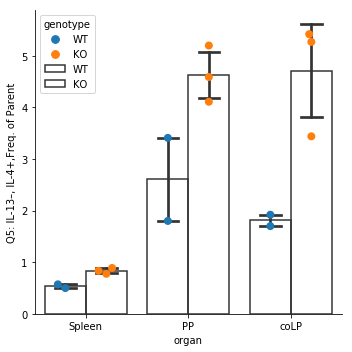

In [99]:
g = sns.catplot(data=df, x="organ", y="Q5: IL-13–, IL-4+,Freq. of Parent", 
             hue="genotype", hue_order=["WT", "KO"], dodge=True, kind="bar",
               linewidth=1.5, facecolor=(1, 0, 1, 0),
                 errcolor=".2", edgecolor="0.2",
               capsize=0.2, ci="sd", legend=False)
sns.swarmplot(data=df, x="organ", y="Q5: IL-13–, IL-4+,Freq. of Parent", 
             hue="genotype", hue_order=["WT", "KO"], dodge=True, s=8, ax=g.ax)
plt.show()

Here I've used matplotlib's `PdfPages` to output a graph of every parameter into 2x2 grids on a landscape letter-size PDF page. Works pretty well! Still need to figure out how to remove the legend for the barplots, since it's redundant with the 

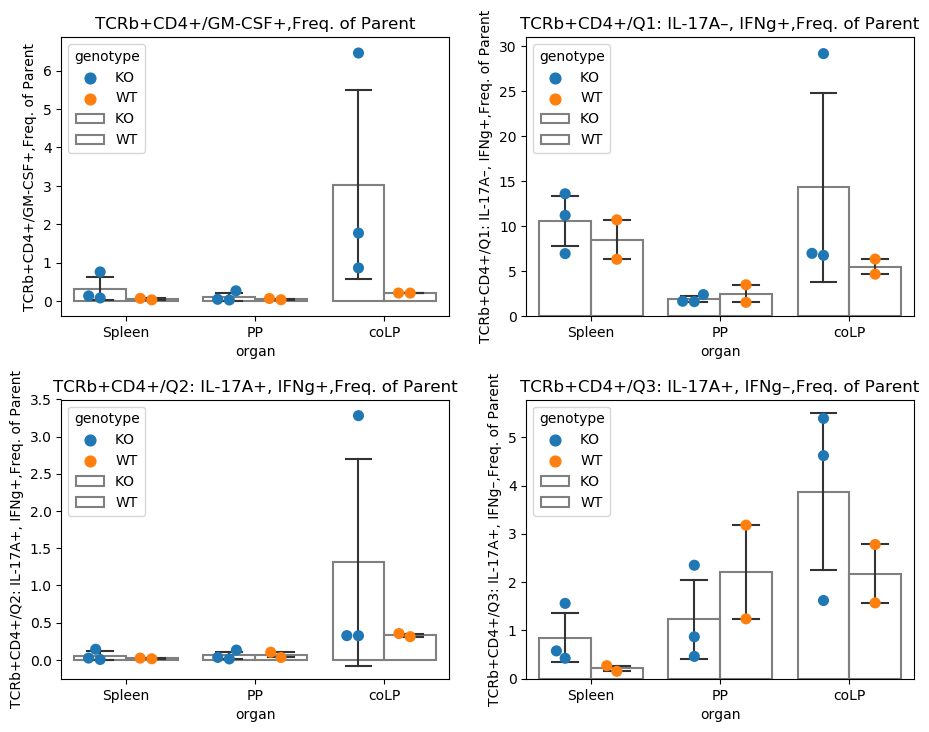

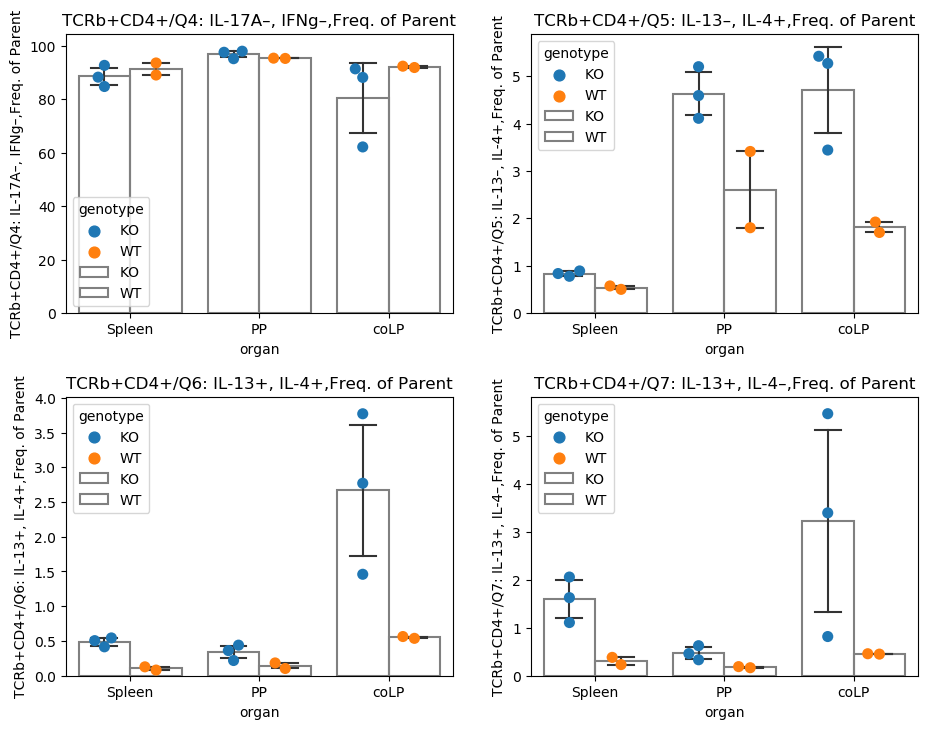

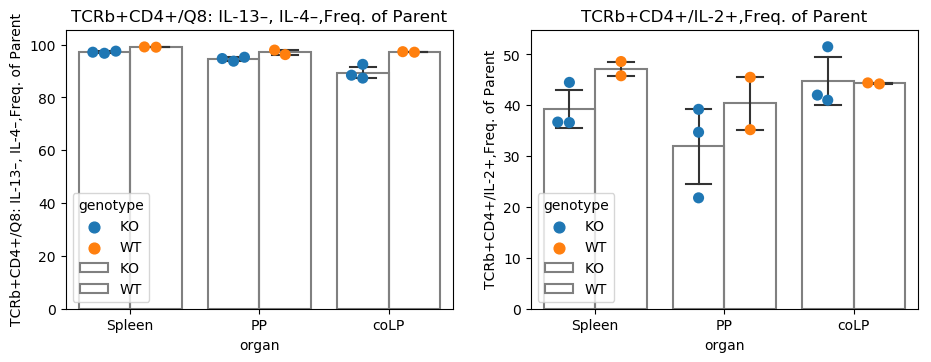

In [26]:
## Output 4 plots per 8.5 x 11 page in landscape
with PdfPages("test.pdf") as pdf:
    ppp = 4 # Plots per page
    for i, var in enumerate(df.columns[3:]):
        if i % ppp == 0:
            fig = plt.figure(figsize=(11, 8.5), dpi=100)
            fig.subplots_adjust(hspace=0.3)
            ax = fig.add_subplot(2, 2, i % ppp + 1)
        else:
            ax = fig.add_subplot(2, 2, i % ppp + 1) 
        sns.catplot(data=df, x="organ", y=var, 
                 hue="genotype", hue_order=np.sort(df['genotype'].unique()), dodge=True, kind="bar",
                   linewidth=1.5, facecolor=(1, 0, 1, 0),
                     errcolor=".2", edgecolor="0.5",
                    errwidth=1.5,
                   capsize=0.2, ci="sd", ax=ax, legend=False)
        ax.legend()
        sns.swarmplot(data=df, x="organ", y=var, 
                 hue="genotype", hue_order=np.sort(df['genotype'].unique()), dodge=True, s=8, ax=ax)
        ax.set_title(var)
        if (i+1) % ppp == 0:
            pdf.savefig(fig)
            plt.close()
        else:
            plt.close()
    if (i+1) % ppp != 0:
        pdf.savefig(fig)

In [ ]:
def makePlots(df, filename):
    with PdfPages(filename) as pdf:
    ppp = 4 # Plots per page
    for i, var in enumerate(df.columns[3:]):
        if i % ppp == 0:
            fig = plt.figure(figsize=(11, 8.5), dpi=100)
            fig.subplots_adjust(hspace=0.3)
            ax = fig.add_subplot(2, 2, i % ppp + 1)
        else:
            ax = fig.add_subplot(2, 2, i % ppp + 1) 
        sns.catplot(data=df, x="organ", y=var, 
                 hue="genotype", dodge=True, kind="bar",
                   linewidth=1.5, facecolor=(1, 0, 1, 0),
                     errcolor=".2", edgecolor="0.5",
                    errwidth=1.5,
                   capsize=0.2, ci="sd", ax=ax, legend=False)
        ax.legend()
        sns.swarmplot(data=df, x="organ", y=var, 
                 hue="genotype", dodge=True, s=8, ax=ax)
        ax.set_title(var)
        if (i+1) % ppp == 0:
            pdf.savefig(fig)
            plt.close()
        else:
            plt.close()
    if (i+1) % ppp != 0:
        pdf.savefig(fig)